In [94]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations
import community
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr
import statsmodels.api as sm


In [2]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [5]:
topologies = []
for count in range(10):
    tree = ete3.Tree('trees/tree_%i.nwk' % count)
    topologies.append(tree.copy())
taxa = tree.get_leaf_names()

In [7]:
spr_distances  = pd.DataFrame(index  =['tree_%i' % num for num in range(len(topologies))],
                              columns=['tree_%i' % num for num in range(len(topologies))],
                              data=[abs(np.arange(10)-n) for n in range(10)])
spr_distances

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0,1,2,3,4,5,6,7,8,9
tree_1,1,0,1,2,3,4,5,6,7,8
tree_2,2,1,0,1,2,3,4,5,6,7
tree_3,3,2,1,0,1,2,3,4,5,6
tree_4,4,3,2,1,0,1,2,3,4,5
tree_5,5,4,3,2,1,0,1,2,3,4
tree_6,6,5,4,3,2,1,0,1,2,3
tree_7,7,6,5,4,3,2,1,0,1,2
tree_8,8,7,6,5,4,3,2,1,0,1
tree_9,9,8,7,6,5,4,3,2,1,0


In [67]:
distance_matrices = {}
with cd('alignments/'):
    for filename in os.listdir('.'):
        if not filename.endswith('.phy'):
            continue
        subprocess.call([
            'iqtree',
            '-s', filename,
            '-pre', filename.split('.')[0],
            '-te', 'BIONJ',
            '-m', 'LG+G',
            '-safe',
            '-keep-ident',
            '-redo',
            '-seed', '12345',
            '-blmax', '100',
        ])
        
        indexes = []
        values  = []
        for line in open('%s.mldist' % filename.split('.')[0]).readlines()[1:]:
            line = line.split()
            indexes.append(line[0])
            values.append(line[1:])
        distance_matrices[filename.split('.')[0]] = pd.DataFrame(
            index=indexes,
            columns=indexes, 
            data=values, 
            dtype=float
        ).reindex(index  =taxa,
                  columns=taxa)

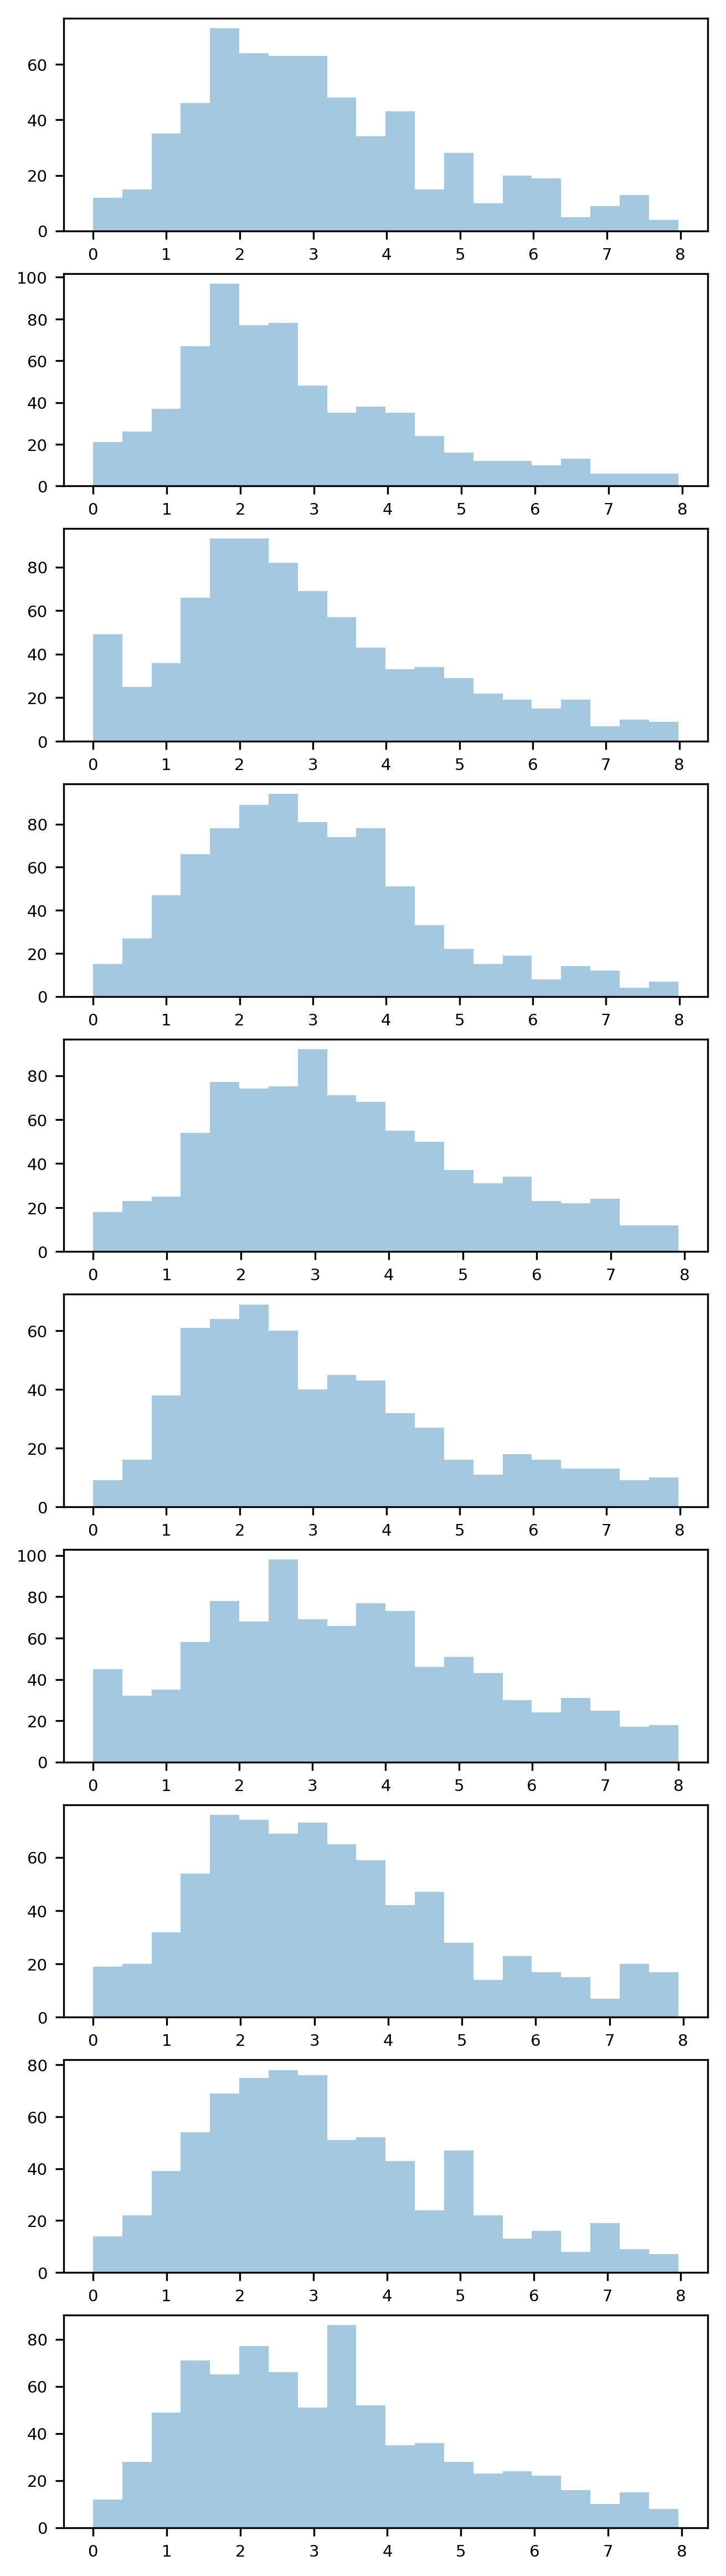

In [71]:
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(figsize=(5,20), dpi=300, nrows=len(distance_matrices))
family_clusters = {}
for num in range(len(topologies)):
    df = distance_matrices['tree_%i' % num]
    condensed_dists = squareform(df.values)
    overlaps        = condensed_dists<=8
    sns.distplot(condensed_dists[overlaps], kde=False, ax=ax[num], bins=20)

In [93]:
family_corrs = []
for family1, family2 in combinations(spr_distances.index, 2):
    
    condensed1 = distance_matrices[family1].values
    condensed2 = distance_matrices[family2].values

    condensed_dists = squareform(df.values)
    overlaps        = condensed_dists<=8

    family_corrs.append(
        pearsonr(
            condensed1[(condensed1<=8) & (condensed2<=8)],
            condensed2[(condensed1<=8) & (condensed2<=8)]
    )[0])
family_corrs = pd.DataFrame(index=spr_distances.index,
                            columns=spr_distances.columns,
                            data=squareform(family_corrs))
family_corrs

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.427684,0.395408,0.412041,0.354489,0.482004,0.351785,0.293280,0.353573,0.286556
tree_1,0.427684,0.000000,0.362506,0.393593,0.371712,0.452165,0.343820,0.352639,0.359592,0.365396
tree_2,0.395408,0.362506,0.000000,0.412307,0.409659,0.421227,0.378819,0.312039,0.179713,0.202202
tree_3,0.412041,0.393593,0.412307,0.000000,0.486817,0.467493,0.330157,0.378156,0.273739,0.451227
tree_4,0.354489,0.371712,0.409659,0.486817,0.000000,0.484930,0.380411,0.451290,0.392006,0.426763
tree_5,0.482004,0.452165,0.421227,0.467493,0.484930,0.000000,0.488448,0.537429,0.435884,0.480579
tree_6,0.351785,0.343820,0.378819,0.330157,0.380411,0.488448,0.000000,0.401649,0.359549,0.240760
tree_7,0.293280,0.352639,0.312039,0.378156,0.451290,0.537429,0.401649,0.000000,0.338573,0.407730
tree_8,0.353573,0.359592,0.179713,0.273739,0.392006,0.435884,0.359549,0.338573,0.000000,0.367156
tree_9,0.286556,0.365396,0.202202,0.451227,0.426763,0.480579,0.240760,0.407730,0.367156,0.000000


In [105]:
pearsonr(squareform(spr_distances), squareform(family_corrs))

(-0.47818377433349607, 0.0008927952539980058)

In [95]:
def huber_loss(residuals, epsilon=1.35):
    # https://en.wikipedia.org/wiki/Huber_loss
    corrected_residuals = []
    for error in residuals:
        if abs(error) <= epsilon:
            corrected_residuals.append((error**2)/2)
        else:
            corrected_residuals.append(epsilon*(abs(error)-epsilon/2))
    return(np.mean(corrected_residuals))

In [106]:
least_square = []
for family1, family2 in combinations(spr_distances.index, 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)
    
    X_filter = X[(X<=8) & (Y<=8)]
    Y_filter = Y[(X<=8) & (Y<=8)]
    X_filter = X_filter.reshape(-1, 1)
    regression = lr(fit_intercept=False).fit(X_filter, Y_filter)

    pred_y = regression.predict(X_filter)
    least_square.append(np.mean((pred_y-Y_filter)**2))

least_square = pd.DataFrame(index  =spr_distances.index,
                            columns=spr_distances.columns,
                            data   =squareform(least_square))
least_square

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,2.518251,3.107782,2.736998,3.641030,3.083270,4.072596,4.376029,3.624414,4.211440
tree_1,2.518251,0.000000,3.215324,2.875456,3.944444,3.198166,4.195343,4.019889,3.957680,4.176138
tree_2,3.107782,3.215324,0.000000,2.886333,3.686583,3.458348,4.662976,4.431538,5.270648,4.780410
tree_3,2.736998,2.875456,2.886333,0.000000,3.062688,3.107190,4.395815,3.701620,4.123009,3.359625
tree_4,3.641030,3.944444,3.686583,3.062688,0.000000,3.162543,4.194030,3.389202,3.749520,3.456081
tree_5,3.083270,3.198166,3.458348,3.107190,3.162543,0.000000,3.084657,2.929168,3.177125,3.139911
tree_6,4.072596,4.195343,4.662976,4.395815,4.194030,3.084657,0.000000,3.642230,3.839703,4.405484
tree_7,4.376029,4.019889,4.431538,3.701620,3.389202,2.929168,3.642230,0.000000,3.906454,3.296895
tree_8,3.624414,3.957680,5.270648,4.123009,3.749520,3.177125,3.839703,3.906454,0.000000,3.757424
tree_9,4.211440,4.176138,4.780410,3.359625,3.456081,3.139911,4.405484,3.296895,3.757424,0.000000


In [107]:
pearsonr(squareform(spr_distances), squareform(least_square))

(0.5389885778521374, 0.00013346531381743798)

In [101]:
huber = []
huber_thresh = 1.35
for family1, family2 in combinations(spr_distances.index, 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)

    X_filter = X[(X<=8) & (Y<=8)]
    Y_filter = Y[(X<=8) & (Y<=8)]
    X_filter = X_filter.reshape(-1, 1)

    regression = hr(epsilon=huber_thresh, fit_intercept=False).fit(X_filter.reshape(-1, 1), Y_filter)
    pred_y     = regression.predict(X_filter.reshape(-1, 1))
    loss_xy    = huber_loss(Y_filter-pred_y)
    
    huber.append(loss_xy)

huber = pd.DataFrame(index  =spr_distances.index,
                     columns=spr_distances.columns,
                     data   =squareform(huber))
huber

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.879444,1.050558,0.974533,1.187478,1.033024,1.284134,1.349407,1.181490,1.334393
tree_1,0.879444,0.000000,1.065777,1.018477,1.229454,1.047644,1.289209,1.266254,1.282482,1.309942
tree_2,1.050558,1.065777,0.000000,1.022319,1.209486,1.117747,1.414052,1.397889,1.584719,1.466755
tree_3,0.974533,1.018477,1.022319,0.000000,1.027143,1.055207,1.344858,1.218449,1.304760,1.127556
tree_4,1.187478,1.229454,1.209486,1.027143,0.000000,1.019731,1.311400,1.151438,1.223913,1.198639
tree_5,1.033024,1.047644,1.117747,1.055207,1.019731,0.000000,1.033978,1.017455,1.028935,1.059221
tree_6,1.284134,1.289209,1.414052,1.344858,1.311400,1.033978,0.000000,1.186778,1.221878,1.444030
tree_7,1.349407,1.266254,1.397889,1.218449,1.151438,1.017455,1.186778,0.000000,1.254861,1.092984
tree_8,1.181490,1.282482,1.584719,1.304760,1.223913,1.028935,1.221878,1.254861,0.000000,1.242380
tree_9,1.334393,1.309942,1.466755,1.127556,1.198639,1.059221,1.444030,1.092984,1.242380,0.000000


In [103]:
pearsonr(squareform(spr_distances), squareform(huber))

(0.5405419668107688, 0.00012652526029044282)

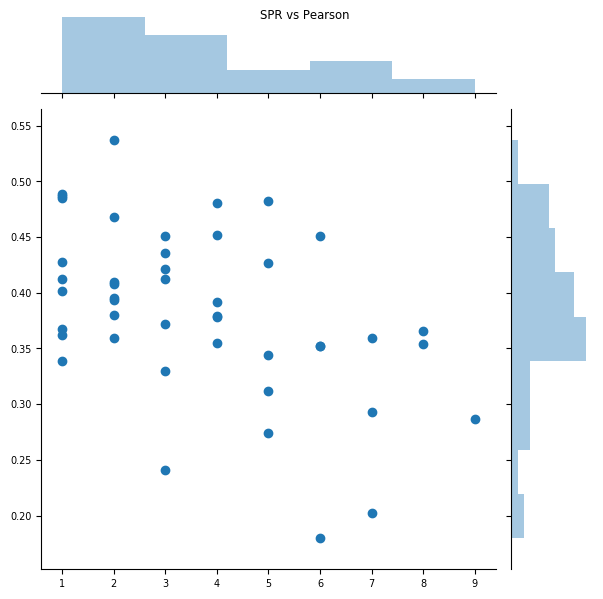

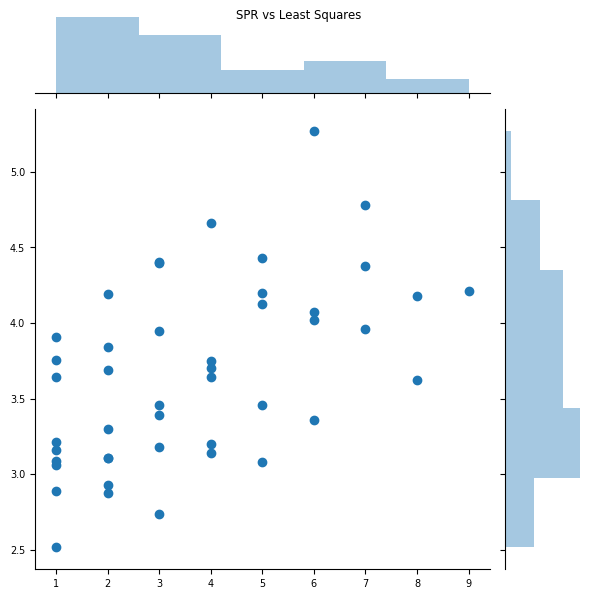

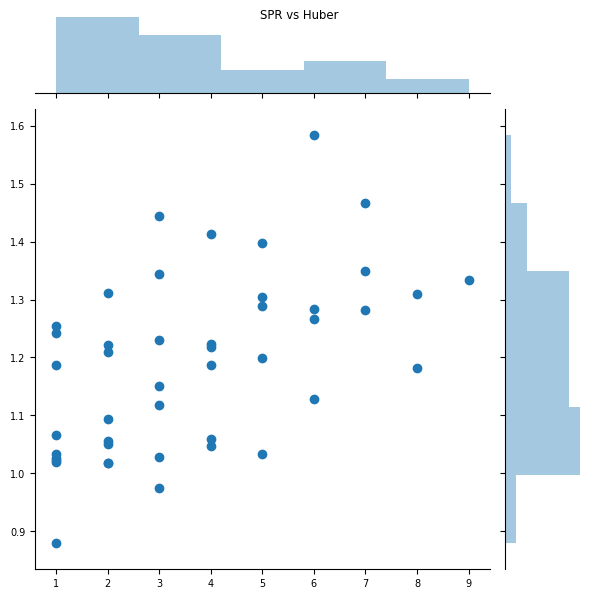

In [108]:
plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(family_corrs))
plot.fig.suptitle('SPR vs Pearson')
plot.fig.set_dpi(100)

plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(least_square))
plot.fig.suptitle('SPR vs Least Squares')
plot.fig.set_dpi(100)

plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(huber))
plot.fig.suptitle('SPR vs Huber')
plot.fig.set_dpi(100)